# Análise exploratória de dados.

### Importando bibliotecas.

In [73]:
import pandas as pd
import csv
import numpy as np
import json
import scipy.stats as stats
import statistics as st
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import r2_score

### Criando listas com os valores utilizados nos processos.

In [74]:
"""
    Listas utilizadas para obter os nomes
    de acordo com a posição e a escolha do menu de opções.
    Está sendo utilizado para imprimir os valores.
"""
PARAMETROS = ["Batimento Cardiaco", "Pressão Arterial", "Temperatura Corporal"]
EXPLORADOS = ["Média", "Mediana", "Desvio Padrão", "Variancia", "Valor Minimo", "Valor Máximo", "Amplitude"]

### Metodos.

In [75]:
"""
  Retorna media de dois valores.
"""
def media(valor1,valor2):
    return (valor1+valor2)/2


"""
    Retorna uma matriz com
    cada item da lista obtida.
"""
def distribuirNaMatriz(lista):
    matriz = []
    
    for valor in lista:
        lista_a = []
        lista_a.append(valor)
        matriz.append(lista_a)    
    return matriz

## Leitura dos dados.

In [76]:
print("------------------------------------------------")
print("0 - Leitura dos dados.")
print("\t São 3 tipos de registros a cada hora e por 100 dias.")
print(f"\t\t1 - {PARAMETROS[0]}, 2 - {PARAMETROS[1]}, 3 - {PARAMETROS[2]}.")

------------------------------------------------
0 - Leitura dos dados.
	 São 3 tipos de registros a cada hora e por 100 dias.
		1 - Batimento Cardiaco, 2 - Pressão Arterial, 3 - Temperatura Corporal.


### Abrindo arquivo, e coletando os valores.

#### Definindo o nome do arquivo com os valores registrados.

In [77]:
dados=[]
path = "sinaisvitais003 100dias DV2 RAxxx5.txt"

In [78]:
with open(path,'r',newline='') as ARQUIVO:
    d = csv.reader(ARQUIVO)
    dd=list(d)
    for i in range(0,len(dd)):
        p=dd[i][0]  
        palavras=p.split("\t")
        dados.append({"HORA":palavras[0],"BATIMENTO":palavras[1],"PRESSAO":palavras[2],"TEMPERATURA":palavras[3]}) 

## Coleta
#### Preparação dos dados.

In [79]:
print("------------------------------------------------")
print("1 - Coleta dos dados.") 
print("\tOs registros do arquivos estão sendo coletados e separados.") 
   
## Coleta dos dados. 
hora=[]
batimento=[]
pressao=[]
temperatura=[]

for i in range(0,len(dados)):
    hora.append(dados[i]["HORA"])
    batimento.append(float(dados[i]["BATIMENTO"]))
    pressao.append(float(dados[i]["PRESSAO"]))
    temperatura.append(float(dados[i]["TEMPERATURA"]))

------------------------------------------------
1 - Coleta dos dados.
	Os registros do arquivos estão sendo coletados e separados.


#### Tratamento dos dados fora da faixa.

In [80]:
print("------------------------------------------------")
print("2 - Limpeza dos dados.")
print("\tSubstituindo os ruido pela média dos valores anterior o posterior.")
"""
    Exercicio 1.
    Limpeza dos dados
    
    1 - Se batimento é menor que zero OU maior que 100.
    2 - Se Pressão é menor que zero OU maior que 20.
    3 - Se Temperatura é menor que zero OU maior que 40.
    
    Para cada condição com ruido, será subistituido peloa
    média do valor anterio e do próximo.
"""

ruidos_batimento = 0
ruidos_pressao = 0
ruidos_temperatura = 0

for i in range(len(dados)):
    if (batimento[i] <= 0) or (batimento[i] > 100):
        batimento[i]=media(batimento[i-1],batimento[i+1])
        ruidos_batimento += 1
    if (pressao[i] <= 0) or (pressao[i] > 20):
        pressao[i]=media(pressao[i-1],pressao[i+1])
        ruidos_pressao += 1
    if (temperatura[i] <= 0) or (temperatura[i] > 40):
        temperatura[i]=media(temperatura[i-1],temperatura[i+1])
        ruidos_temperatura += 1

------------------------------------------------
2 - Limpeza dos dados.
	Substituindo os ruido pela média dos valores anterior o posterior.


In [81]:
# ORGANIZANDO UM DATAFAME COM OS DADOS DISPONIBILIZADOS NO ARQUIVO   
auxDF=[]  
auxDF+=[(batimento[j],pressao[j],temperatura[j]) for j in range(100)]  
DFdados = pd.DataFrame(auxDF, columns=[PARAMETROS[0],PARAMETROS[1],PARAMETROS[2]])

# FERRAMENTA GERAL
print("\nDADOS ESTATISTICOS BÁSICOS - TEMPORAL - POR HORA: ")
print("NUMERO DE AMOSTRAS/CAMPOS: ",DFdados.shape)


DADOS ESTATISTICOS BÁSICOS - TEMPORAL - POR HORA: 
NUMERO DE AMOSTRAS/CAMPOS:  (100, 3)


#### Dados do DadaFrame com as amostras;

In [82]:
DFdados

,Batimento Cardiaco,Pressão Arterial,Temperatura Corporal
0,66.535898,10.267949,36.714259
1,66.935822,10.467911,36.635056
2,67.428850,10.714425,36.506828
3,68.000000,11.000000,36.979759
4,68.631919,11.315960,36.677503
...,...,...,...
95,70.625468,12.306296,36.461791
96,66.418775,10.256365,36.574060
97,66.851518,10.412917,36.844450
98,67.337589,10.640939,36.817614


#### Dados estatisticos do DadaFrame com as amostras;

In [83]:
# Avaliar código.

# dados = DFdados.describe()
# #print(dados)
# for i in dados.items():
#     print("\n", i)

In [84]:
DFdados.describe()

,Batimento Cardiaco,Pressão Arterial,Temperatura Corporal
count,100.000000,100.000000,100.000000
mean,71.151372,12.579703,36.761657
std,2.468810,1.235526,0.138314
min,66.418775,10.256365,36.456422
25%,69.227413,11.629365,36.670329
50%,71.963462,12.973132,36.793689
75%,73.389800,13.697876,36.878793
max,74.000000,14.000000,36.979759


#### Organizando os dados em 24 amostra por dia.

In [85]:
print("------------------------------------------------")
print("3 - Tratamento dos dados.")
print("\tOrcanizando os dados em listas, incluindo a cada 24h Uma nova lista.")
"""
    Separando os dias por dias
    contendo os registros das 24 horas.
"""
matriz_batimento = []
lista_b24 = []

matriz_pressao = []
lista_p24 = []

matriz_temperatura= []
lista_t24 = []


h = 0
# Percorrendo a quantidade de registro do arquivo.
for i in range(len(dados)):
    
    # Incluindo os registros no dia i
    lista_b24.append(batimento[i])
    lista_p24.append(pressao[i])
    lista_t24.append(temperatura[i])
    
    # Hora atual recebe ela mesma mais 1.
    # referente a hora do registro.
    h += 1
    
    # Se a hora atual for igual 24. Então
    if(h == 24):
        
        # Incluindo a lista com os 24 registros. Na posição dia i.
        matriz_batimento.append(lista_b24)
        matriz_pressao.append(lista_p24)
        matriz_temperatura.append(lista_t24)
        
        # lista a lista com os registros do dia i.
        lista_b24 = []
        lista_p24 = []
        lista_t24 = []
        
        # Zera a hora, para iniciar o proximo dia.
        h = 0

# Criando uma matriz com os dia, e contendos as 24 amostras.
matriz_master = []
matriz_master.append(matriz_batimento)
matriz_master.append(matriz_pressao)
matriz_master.append(matriz_temperatura)

"""
 matriz_master[A][B][C]
 A - os parâmetros coletados.
 B - são os dias que fotam coletados, de 1 até 100.
 C - são as horas do dia. de 1 até 24.
"""

------------------------------------------------
3 - Tratamento dos dados.
	Orcanizando os dados em listas, incluindo a cada 24h Uma nova lista.


'\n matriz_master[A][B][C]\n A - os parâmetros coletados.\n B - são os dias que fotam coletados, de 1 até 100.\n C - são as horas do dia. de 1 até 24.\n'

#### Exibindos dados referente ao dia selecioando.

In [88]:
dia = 81

# ORGANIZANDO UM DATAFAME COM OS DADOS DISPONIBILIZADOS NO ARQUIVO   
auxDF=[]  
auxDF+=[(matriz_master[0][dia-1][j],matriz_master[1][dia-1][j],matriz_master[2][dia-1][j]) for j in range(24)]  
DFdados = pd.DataFrame(auxDF, columns=[PARAMETROS[0],PARAMETROS[1],PARAMETROS[2]])

# FERRAMENTA GERAL
print("\nDADOS ESTATISTICOS BÁSICOS - TEMPORAL - POR HORA: ")
print(f"NUMERO DE AMOSTRAS/CAMPOS DO DIA {dia-1}: ",DFdados.shape)


DADOS ESTATISTICOS BÁSICOS - TEMPORAL - POR HORA: 
NUMERO DE AMOSTRAS/CAMPOS DO DIA 80:  (24, 3)


#### Dados diário.

In [89]:
DFdados

,Batimento Cardiaco,Pressão Arterial,Temperatura Corporal
0,64.503825,9.729086,36.763119
1,64.703031,10.105632,36.844864
2,66.319785,10.025511,36.811451
3,65.401889,9.935469,36.690867
4,65.248059,10.730222,36.521944
5,66.659549,11.530557,36.850798
6,67.974207,10.650933,36.935612
7,70.300274,12.072322,37.098667
8,68.882076,12.218871,36.783553
9,71.167205,12.115650,37.349832


#### Dados estatísticos diário.

In [91]:
DFdados.describe()

,Batimento Cardiaco,Pressão Arterial,Temperatura Corporal
count,24.000000,24.000000,24.000000
mean,69.411140,11.939379,36.966160
std,2.796576,1.215269,0.243346
min,64.503825,9.729086,36.521944
25%,67.438584,10.798231,36.794267
50%,70.333054,12.167261,36.931577
75%,71.437804,12.925556,37.164784
max,73.495188,13.518117,37.402144


### Extraindo os dados.

In [106]:
print("------------------------------------------------")
print("4 - Mineração dos dados.")
print("\tExtraindo os valores dos dados coletados.")
"""
    Extraindo os seguintes valores.
        1 - Média de cada dia.
        2 - Médiana de cada dia.
        3 - Desvio Padrão.
        4 - Variancia.
        5 - amplitude
"""
u = 1

dados_extraidos = []
dados_batimento = []
dados_pressao = []
dados_temperatura = []

# listas para os dados extraidos do batimento.
dados_m_b = []
dados_md_b = []
dados_dp_b = []
dados_v_b = []
dados_min_b = []
dados_max_b = []
dados_amp_b = []

# listas para os dados extraidos da pressão.
dados_m_p = []
dados_md_p = []
dados_dp_p = []
dados_v_p = []
dados_min_p = []
dados_max_p = []
dados_amp_p = []

# listas para os dados extraidos da temperatura.
dados_m_t = []
dados_md_t = []
dados_dp_t = []
dados_v_t = []
dados_min_t = []
dados_max_t = []
dados_amp_t = []

for a in range(100):
    
    # Valores de cada parametros coletados.
    b = matriz_master[0][a]
    p = matriz_master[1][a]
    t = matriz_master[2][a]
    
    # Obtendo os valores do batimento, e incluindo nas listas definidas.
    dados_m_b.append(np.average(b))
    dados_md_b.append(np.median(b))
    dados_dp_b.append(np.std(b))
    dados_v_b.append(np.var(b))
    dados_min_b.append(min(b))
    dados_max_b.append(max(b))
    dados_amp_b.append((max(b) - min(b)))
    
    # Obtendo os valores da pressão, e incluindo nas listas definidas.
    dados_m_p.append(np.average(p))
    dados_md_p.append(np.median(p))
    dados_dp_p.append(np.std(p))
    dados_v_p.append(np.var(p))
    dados_min_p.append(min(p))
    dados_max_p.append(max(p))
    dados_amp_p.append((max(p) - min(p)))
    
    # Obtendo os valores da temperatura, e incluindo nas listas definidas.
    dados_m_t.append(np.average(t))
    dados_md_t.append(np.median(t))
    dados_dp_t.append(np.std(t))
    dados_v_t.append(np.var(t))
    dados_min_t.append(min(t))
    dados_max_t.append(max(t))
    dados_amp_t.append((max(t) - min(t)))
    
    u += 1

# Incluindos as listas dos valores extridos, e incluindo na lista do Batimento.
dados_batimento.append(dados_m_b)
dados_batimento.append(dados_md_b)
dados_batimento.append(dados_dp_b)
dados_batimento.append(dados_v_b)
dados_batimento.append(dados_min_b)
dados_batimento.append(dados_max_b)
dados_batimento.append(dados_amp_b)

# Incluindos as listas dos valores extridos, e incluindo na lista do Pressão.
dados_pressao.append(dados_m_p)
dados_pressao.append(dados_md_p)
dados_pressao.append(dados_dp_p)
dados_pressao.append(dados_v_p)
dados_pressao.append(dados_min_p)
dados_pressao.append(dados_max_p)
dados_pressao.append(dados_amp_p)

# Incluindos as listas dos valores extridos, e incluindo na lista da Temperatura.
dados_temperatura.append(dados_m_t)
dados_temperatura.append(dados_md_t)
dados_temperatura.append(dados_dp_t)
dados_temperatura.append(dados_v_t)
dados_temperatura.append(dados_min_t)
dados_temperatura.append(dados_max_t)
dados_temperatura.append(dados_amp_t)

# Incluindo na matriz, as três listas, contendo suas listas de valores extraidos.
dados_extraidos.append(dados_batimento)
dados_extraidos.append(dados_pressao)
dados_extraidos.append(dados_temperatura)

"""
Os valores extraidos estão
com a seguinte estrutura:

dados_extraidos[A][B][C]

A - São os Atributos.
    0 - Batimento.
    1 - Pressao.
    2 - Temperatura.

B - São os dados extraiso.
    0 - Media
    1 - Mediana.
    2 - Desvio Padrão.
    3 - Variancia
    4 - Valor Minimo.
    5 - Valor maximo.
    6 - Amplitute.

C - É o valor referente ao dia.
    0 - primeiro dia.
    ...
    99 - último dia.
"""
print("------------------------------------------------")

------------------------------------------------
4 - Mineração dos dados.
	Extraindo os valores dos dados coletados.
------------------------------------------------


#### Obotendo valor do dados extraido selecionado e do dia selecionado.

In [120]:
dia = int(input("Digite o dia desejado? "))
print(EXPLORADOS)
valor = int(input("Digite a posição do valor desejado? "))

# ORGANIZANDO UM DATAFAME COM OS DADOS DISPONIBILIZADOS NO ARQUIVO   
auxDF=[]  
auxDF+=[(dados_extraidos[0][valor-1][dia-1],dados_extraidos[1][valor-1][dia-1],dados_extraidos[2][valor-1][dia-1])]  
DFdados = pd.DataFrame(auxDF, columns=[PARAMETROS[0],PARAMETROS[1],PARAMETROS[2]])

# FERRAMENTA GERAL
print(f"\n{EXPLORADOS[valor]} do dia {dia-1}")
print(f"NUMERO DE AMOSTRAS/CAMPOS DO: ",DFdados.shape)


Digite o dia desejado? 52
['Média', 'Mediana', 'Desvio Padrão', 'Variancia', 'Valor Minimo', 'Valor Máximo', 'Amplitude']
Digite a posição do valor desejado? 2

Desvio Padrão do dia 51
NUMERO DE AMOSTRAS/CAMPOS DO:  (1, 3)


#### Dados do valor extradido estatisticos escolhido e dia escolhido.

In [121]:
DFdados

,Batimento Cardiaco,Pressão Arterial,Temperatura Corporal
0,70.033062,12.633504,36.879264


## Correlação 

#### Preparação dos dados da correlação diária.

In [109]:
CORBATIMENTO_BATIMENTO = []
CORBATIMENTO_PRESSAO = []
CORBATIMENTO_TEMPERATURA = []

BATIMENTO = []

for i in range(100):
    PauxDF=[]  
    PauxDF+=[(matriz_master[0][i][j],matriz_master[1][i][j],matriz_master[2][i][j]) for j in range(24)]  
    PDFdados = pd.DataFrame(PauxDF, columns=["BATIMENTO","PRESSAO","TEMPERATURA"])
    
    # CALCULAR A CORRELAÇÃO
    correlacao = PDFdados.corr(method='pearson')

    #SALVANDO CORRELACAO GELADEIRA x OUTROS
    CORBATIMENTO_BATIMENTO.append(correlacao["BATIMENTO"][0])
    CORBATIMENTO_PRESSAO.append(correlacao["PRESSAO"][0])
    CORBATIMENTO_TEMPERATURA.append(correlacao["TEMPERATURA"][0])
    BATIMENTO.append(PDFdados["BATIMENTO"])

In [115]:
# ORGANIZANDO UM DATAFAME COM OS DADOS DISPONIBILIZADOS NO ARQUIVO   
auxDF=[]  
auxDF+=[(CORBATIMENTO_BATIMENTO[j],CORBATIMENTO_PRESSAO[j], CORBATIMENTO_TEMPERATURA[j]) for j in range(100)]  
DFdados = pd.DataFrame(auxDF, columns=[PARAMETROS[0], PARAMETROS[1],PARAMETROS[2]])

# FERRAMENTA GERAL
print("\nDADOS ESTATISTICOS BÁSICOS - TEMPORAL - POR HORA: ")
print("NUMERO DE AMOSTRAS/CAMPOS: ",DFdados.shape)


DADOS ESTATISTICOS BÁSICOS - TEMPORAL - POR HORA: 
NUMERO DE AMOSTRAS/CAMPOS:  (100, 3)


#### Tabela da Correlação dos valores de cada dia.

In [116]:
DFdados

,Batimento Cardiaco,Pressão Arterial,Temperatura Corporal
0,1.0,1.000000,0.408096
1,1.0,0.999983,0.562201
2,1.0,0.999855,0.180514
3,1.0,0.999815,0.558711
4,1.0,0.999693,0.474752
...,...,...,...
95,1.0,0.749089,0.485575
96,1.0,0.837523,0.364283
97,1.0,0.798119,0.742953
98,1.0,0.819865,0.799904


### Amplitude da correlação

In [110]:
# Lista que receberá a amplitude dos valores.
AMPLITUDE = []
for i in range(100):
    x = CORBATIMENTO_PRESSAO[i] - CORBATIMENTO_TEMPERATURA[i]
    AMPLITUDE.append(x)

### Obetendo a média da amplitude.

#### Percorrendo por cada valor na amplitude.
#### Comparando a amplitude diário com a média.

#### Criando duas listas, acima da média e outra abaixo da média.
#### Para a lista abaixo da média, para volores acima da média está sendo substituido pela média.
#### O inverso para a lista com os valores acima da média.

In [111]:
# Média da amplitude.
m = np.average(AMPLITUDE)

# Lista que receberá os valores.
# Valores que não são das lista será
# subistituido pela média.
AMPLITUDE_ABAIXO_DA_MEDIA = []
AMPLITUDE_ACIMA_DA_MEDIA = []

for i in AMPLITUDE:  
    if(i > m):
        AMPLITUDE_ABAIXO_DA_MEDIA.append(m)
        AMPLITUDE_ACIMA_DA_MEDIA.append(i)
    else:
        AMPLITUDE_ABAIXO_DA_MEDIA.append(i)
        AMPLITUDE_ACIMA_DA_MEDIA.append(m)

In [112]:
# ORGANIZANDO UM DATAFAME COM OS DADOS DISPONIBILIZADOS NO ARQUIVO   
auxDF=[]  
auxDF+=[(AMPLITUDE_ABAIXO_DA_MEDIA[j],AMPLITUDE_ACIMA_DA_MEDIA[j]) for j in range(100)]  
DFdados = pd.DataFrame(auxDF, columns=["Abaixo da média", "Acima da média."])

# FERRAMENTA GERAL
print("\nDADOS ESTATISTICOS BÁSICOS - TEMPORAL - POR HORA: ")
print("NUMERO DE AMOSTRAS/CAMPOS: ",DFdados.shape)


DADOS ESTATISTICOS BÁSICOS - TEMPORAL - POR HORA: 
NUMERO DE AMOSTRAS/CAMPOS:  (100, 2)


#### Dados da Amplitude.

In [113]:
DFdados

,Abaixo da média,Acima da média.
0,0.363938,0.591904
1,0.363938,0.437781
2,0.363938,0.819341
3,0.363938,0.441104
4,0.363938,0.524941
...,...,...
95,0.263514,0.363938
96,0.363938,0.473240
97,0.055167,0.363938
98,0.019961,0.363938


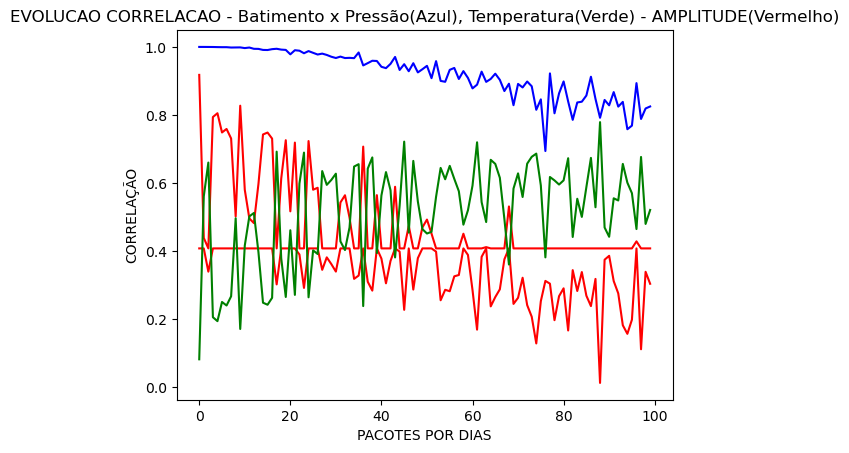

In [107]:
# Plotando a correlação.
plt.plot(AMPLITUDE_ACIMA_DA_MEDIA,'r')
plt.plot(AMPLITUDE_ABAIXO_DA_MEDIA,'r')
plt.plot(CORBATIMENTO_PRESSAO,'b')
plt.plot(CORBATIMENTO_TEMPERATURA,'g')
plt.title("EVOLUCAO CORRELACAO - Batimento x Pressão(Azul), Temperatura(Verde) - AMPLITUDE(Vermelho)")
plt.xlabel("PACOTES POR DIAS")
plt.ylabel("CORRELAÇÃO")
plt.show()

### A correlação 

In [108]:
print("5 - Análise de conteúdo.")
print("\tCorrelação entre os três parâmetros.")

v = []
for i in range(100):
    auxDF=[]
    auxDF+=[(float(matriz_master[0][i][j]),float(matriz_master[1][i][j]),float(matriz_master[2][i][j])) for j in range(0,24)]
    DataFrame=[]
    # MONTAGEM
    DataFrame = pd.DataFrame(auxDF,columns=[PARAMETROS[0], PARAMETROS[1], PARAMETROS[2]])

    v.append(DataFrame.corr(method='pearson'))
print("------------------------------------------------")

5 - Análise de conteúdo.
	Correlação entre os três parâmetros.
------------------------------------------------


### Correlação dos três parâmetros referente ao dia definido.
#### Enquanto for Verdadeiro irá executar. 



	*************** Menu de opções  ***************
	**	Digite o dia desejado (de 1 até 100)? 63
	***** *************************************** *****


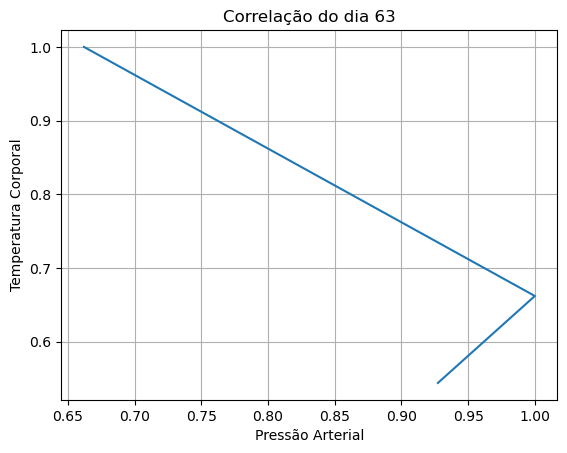



	*************** Opções de sair.  ***************
	**	Deseja continuar?
	**	S - SIM, N - NÃO? n
	***** ************************************ *****


In [109]:
while True:
    try:
        print("\n\n\t*************** Menu de opções  ***************")
        dia = int(input("\t**\tDigite o dia desejado (de 1 até 100)? "))
        
    except ValueError:
        print("\t**\tERRO - Valor fora do padrão, digite um valor número inteiro.")
    
    
    if((dia > 0) and (dia <= 100)):
        print("\t***** *************************************** *****")
        auxDF=[]
        auxDF+=[(float(matriz_master[0][dia-1][j]), float(matriz_master[1][dia-1][j]), float(matriz_master[2][dia-1][j])) for j in range(0,24)]
        DataFrame=[]
        # MONTAGEM
        DataFrame = pd.DataFrame(auxDF,columns=[PARAMETROS[0], PARAMETROS[1], PARAMETROS[2]])
    
    
        x = DataFrame.corr(method='pearson')[PARAMETROS[1]]
        y = DataFrame.corr(method='pearson')[PARAMETROS[2]]
    
        plt.plot(x, y)
        plt.title(f"Correlação do dia {dia}")
        plt.xlabel(PARAMETROS[1])
        plt.ylabel(PARAMETROS[2])
        plt.grid()
        plt.show()
        
        print("\n\n\t*************** Opções de sair.  ***************")
        opcao_p = input("\t**\tDeseja continuar?\n\t**\tS - SIM, N - NÃO? ")
        print("\t***** ************************************ *****")
        
        if((opcao_p == "N") or (opcao_p == "n")):
            break
    else:
        print("\t**\tOPÇÃO INVÁLIDA. TENTE NOVAMENTE!")

### Avaliando a Correlação dos Três parâmetros.
#### Batimento - Pressão - Temperatura.

In [110]:
print("------------------------------------------------")
print("\tCorrelação entre os três parâmetros.")

batimento = []
pressao = []
temperatura = []

for i in matriz_master[0]:
    for u in i:
        batimento.append(u)
for i in matriz_master[1]:
    for u in i:
        pressao.append(u)
for i in matriz_master[2]:
    for u in i:
        temperatura.append(u)

auxDF=[]
auxDF+=[(float(batimento[j]), float(pressao[j]), float(temperatura[j])) for j in range(0,100)]
DataFrame=[]

# MONTAGEM
DataFrame = pd.DataFrame(auxDF,columns=[PARAMETROS[0], PARAMETROS[1], PARAMETROS[2]])
# print(DataFrame.corr(method='pearson'))   


x = DataFrame.corr(method='pearson')


itens=[]

for i in x:
    itens.append(i)
    st=x[i]
    sst=[]
    for j in range(len(st)):
        sst.append(str(st[j])+" ")

# p posição do indece.
# i valor do indece.
for p , i in enumerate(x):
    print("--")
    
    st=x[i]
    for j in range(p, len(st)):
        print("-")
        #print(a) 
        if(p != j):
            if (st[j] >= 0.8):
                print(f"O ",itens[p]," E ",itens[j],"APRESENTA ALTA CORRELAÇÃO, PROPOR ALGO.")
            elif((st[j] >= 0.5) and (st[j] < 0.8)):
                print(f"O ",itens[p]," E ",itens[j],"APRESENTA ALGUMA CORRELAÇÃO, PROPOR DIVULGAÇÃO")
            else:
                print(f"O ",itens[p]," E ",itens[j],"APRESENTA BAIXA CORRELAÇÃO, AVALIAR POSSIBILIDADES.")
print("------------------------------------------------")

------------------------------------------------
	Correlação entre os três parâmetros.
--
-
-
O  Batimento Cardiaco  E  Pressão Arterial APRESENTA ALTA CORRELAÇÃO, PROPOR ALGO.
-
O  Batimento Cardiaco  E  Temperatura Corporal APRESENTA BAIXA CORRELAÇÃO, AVALIAR POSSIBILIDADES.
--
-
-
O  Pressão Arterial  E  Temperatura Corporal APRESENTA BAIXA CORRELAÇÃO, AVALIAR POSSIBILIDADES.
--
-
------------------------------------------------


### Avaliando a correlação entre os valores extraidos do Batimento.

In [111]:
print("------------------------------------------------")
print("\tCorrelação entre os dados extraidos dos três parâmetros.")
auxDF=[]
auxDF+=[(float(dados_extraidos[0][0][j]), float(dados_extraidos[0][1][j]), float(dados_extraidos[0][2][j]), float(dados_extraidos[0][3][j]), float(dados_extraidos[0][4][j]), float(dados_extraidos[0][5][j]), float(dados_extraidos[0][6][j])) for j in range(0,24)]
DataFrame=[]
# MONTAGEM
DataFrame = pd.DataFrame(auxDF,columns=[EXPLORADOS[0], EXPLORADOS[1], EXPLORADOS[2], EXPLORADOS[3], EXPLORADOS[4], EXPLORADOS[5], EXPLORADOS[6]])
print(DataFrame.corr()) 

x = DataFrame.corr(method='pearson')

itens=[]

for i in x:
    #print("PARÂMETRO: ",i)
    itens.append(i)
    st=x[i]
    sst=[]
    for j in range(len(st)):
        sst.append(str(st[j])+" ")

# p posição do indece.
# i valor do indece.
for p , i in enumerate(x):
    print("--")
    
    st=x[i]
    for j in range(p,len(st)):
#         print("-")
        #print(a) 
        if(p != j):
            if (st[j] >= 0.8):
                print(f"{PARAMETROS[0]} - ",itens[p]," E ",itens[j]," APRESENTA ALTA CORRELAÇÃO, Atebção.")
            elif(st[j] >= 0.5) and (st[j] < 0.8):
                print(f"{PARAMETROS[0]} - ",itens[p]," E ",itens[j]," APRESENTA ALGUMA CORRELAÇÃO, Propor algo.")
            else:
                print(f"{PARAMETROS[0]} - ",itens[p]," E ",itens[j]," APRESENTA BAIXA CORRELAÇÃO, Avaliar.")


------------------------------------------------
	Correlação entre os dados extraidos dos três parâmetros.
                  Média   Mediana  Desvio Padrão  Variancia  Valor Minimo  \
Média          1.000000  0.763405      -0.333509  -0.342863      0.802826   
Mediana        0.763405  1.000000      -0.086659  -0.095195      0.590755   
Desvio Padrão -0.333509 -0.086659       1.000000   0.999804     -0.622501   
Variancia     -0.342863 -0.095195       0.999804   1.000000     -0.627243   
Valor Minimo   0.802826  0.590755      -0.622501  -0.627243      1.000000   
Valor Máximo   0.670878  0.587373       0.233416   0.220484      0.366913   
Amplitude     -0.523922 -0.338838       0.781690   0.780316     -0.886121   

               Valor Máximo  Amplitude  
Média              0.670878  -0.523922  
Mediana            0.587373  -0.338838  
Desvio Padrão      0.233416   0.781690  
Variancia          0.220484   0.780316  
Valor Minimo       0.366913  -0.886121  
Valor Máximo       1.000000   

### Exibindo os graficos para analise, obtendo o perfil da curva, e Histograma.
#### Enquanto for Verdadeiro irá executar. 



	*************** Menu de opções  ***************

	**	1 - Batimento.
	**	2 - Pressão
	**	3 - Temperatura

	**	Qual sua opção? 1


	***************

	**	1 - Média.
	**	2 - Mediana
	**	3 - Desvio Padrão.
	**	4 - Variancia.
	**	5 - Valor Minimo
	**	6 - Valor Maximo
	**	7 - Amplitude.

	**	Qual sua opção? 1
	***** *************************************** *****

	Média de Batimento Cardiaco por 100 dias.


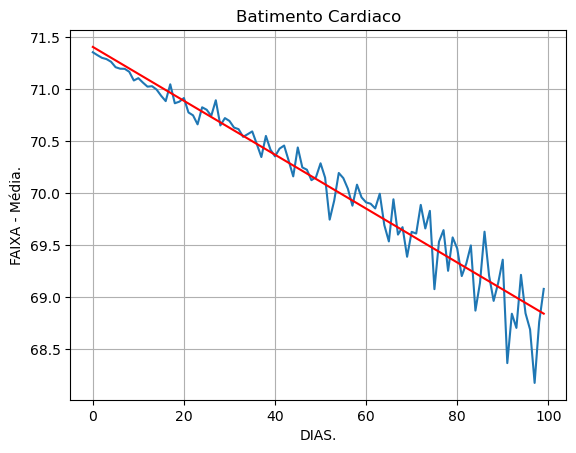

------------------------------------------------
	Histograma - Batimento Cardiaco


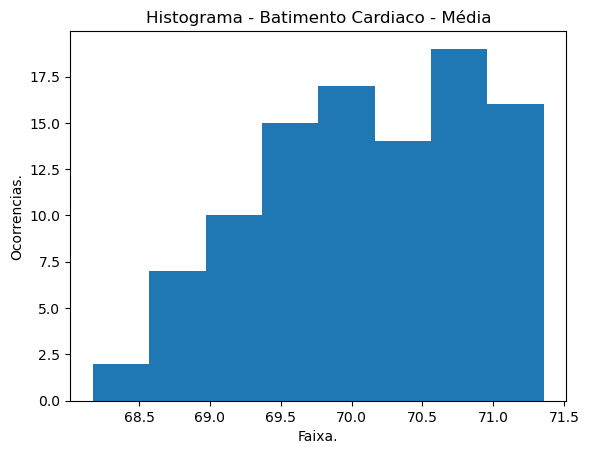

Deseja continuar?
S - SIM, N - NÃO
n


In [112]:
## Criando a lista, com os dias.
## Utilizado para obter o perfil da curva.
dia = 100
dias = []
for i in range(dia): dias.append(i)


while True:
    try:
        print("\n\n\t*************** Menu de opções  ***************")
        opcao_p = int(input("\n\t**\t1 - Batimento.\n\t**\t2 - Pressão\n\t**\t3 - Temperatura\n\n\t**\tQual sua opção? "))
        print("\n\n\t***************")
        opcao_e = int(input("\n\t**\t1 - Média.\n\t**\t2 - Mediana\n\t**\t3 - Desvio Padrão.\n\t**\t4 - Variancia.\n\t**\t5 - Valor Minimo\n\t**\t6 - Valor Maximo\n\t**\t7 - Amplitude.\n\n\t**\tQual sua opção? "))
        
        
    except ValueError:
        print("\t**\tERRO - Valor fora do padrão, digite um valor número inteiro.")
    
    if(((opcao_p > 0) and (opcao_p <=3)) and ((opcao_e > 0) and (opcao_e <= 7))):
        print("\t***** *************************************** *****\n")
    
        print(f"\t{EXPLORADOS[opcao_e-1]} de {PARAMETROS[opcao_p-1]} por {dia} dias.")
        plt.plot(dias, dados_extraidos[opcao_p-1][opcao_e-1])
        plt.title(f"{PARAMETROS[opcao_p-1]}")
        plt.xlabel("DIAS.")
        plt.ylabel(f"FAIXA - {EXPLORADOS[opcao_e-1]}.")

        """
            Essa etapa faz a
            avaliação do perfil da curva.
            Foi criado um metodo distribuirNaMatriz(X[..])
            Onde é enviado uma lista com os valores
            e retorna matriz com os valores em cada lista.
        """
        regressao=linear_model.LinearRegression()
        horas_d = np.array(distribuirNaMatriz(dias))
        valores =np.array(distribuirNaMatriz(dados_extraidos[opcao_p-1][opcao_e-1]))
        regressao.fit(horas_d,valores)
        plt.plot(horas_d, horas_d*regressao.coef_[0][0] + regressao.intercept_, color='red')
        
        # incluindo grades no grafico.
        plt.grid()
        plt.show()
        print("------------------------------------------------")
        print(f"\tHistograma - {PARAMETROS[opcao_p-1]}")
        # Histograma.
        hist=np.histogram(dados_extraidos[opcao_p-1][opcao_e-1])
        # Plotar dados.
        plt.hist(dados_extraidos[opcao_p-1][opcao_e-1],bins='auto')
        plt.title(f"Histograma - {PARAMETROS[opcao_p-1]} - {EXPLORADOS[opcao_e-1]}")
        plt.xlabel("Faixa.")
        plt.ylabel("Ocorrencias.")
        plt.show()

        print("\n\n\t*************** Opções de sair.  ***************")
        opcao_p = input("\t**\tDeseja continuar?\n\t**\tS - SIM, N - NÃO? ")
        print("\t***** ************************************ *****")
        
        # Se opação for igual "N" Não.Então
        # irá parar o loop do while.
        if((opcao_p == "N") or (opcao_p == "n")):
            break
            
    else:
        print("\t**\tOPÇÃO INVÁLIDA. TENTE NOVAMENTE!")

## Verificando se o registro diário está abaixo ou acima. Exibindo uma mensagem.
### Apenas Para a Média e Mediana.
#### Enquanto for Verdadeiro irá executar. 

In [ ]:
while True:
    try:
        print("\n\n\t*************** Menu de opções  ***************")
        opcao_p = int(input("\n\t**\t1 - Batimento.\n\t**\t2 - Pressão\n\t**\t3 - Temperatura\n\n\t**\tQual sua opção? "))
        print("\n\n\t***************")
        opcao_e = int(input("\n\t**\t1 - Média.\n\t**\t2 - Mediana\n\t**\t3 - Desvio Padrão.\n\t**\t4 - Variancia.\n\t**\t5 - Valor Minimo\n\t**\t6 - Valor Maximo\n\t**\t7 - Amplitude.\n\n\t**\tQual sua opção? "))
        
        
    except ValueError:
        print("\t**\tERRO - Valor fora do padrão, digite um valor número inteiro.")
    
    if(((opcao_p > 0) and (opcao_p <=3)) and ((opcao_e > 0) and (opcao_e <= 7))):
        print("\t***** *************************************** *****\n")
        
        """
        Laço que percorre a matriz com os 100 dias de batimento cariaco.
        Onde i é a lista com 24 registros do batimento.
        """
        dia = 0
        p = opcao_p-1
        v = opcao_e-1
        for i in matriz_master[p]:

            hora = 0
            acima = 0
            abaixo = 0
            """
            Laço que percorre a lista com os 24 registros.
            """
            for x in i:

                # Se valor é igual a média, ou igula a mediana.
                if((v == 0) or (v == 1)):
                    if(x > dados_extraidos[p][v][dia]):
                        print(f"\t\t{hora+1}h - {x} - {PARAMETROS[p]} acima da {EXPLORADOS[v]}.")
                        print(f"\t\t\t Alerta!!! Acima d. {PARAMETROS[p]} diária.")
                        acima += 1
                    elif(x < dados_extraidos[p][v][dia]):
                        print(f"\t\t{hora+1}h - {x} - {PARAMETROS[p]} a baixo da {EXPLORADOS[v]}.")
                        abaixo += 1
                    else:
                        print(f"\t\t{hora+1}h - {x} - {PARAMETROS[p]} na {EXPLORADOS[v]}.")
                    hora += 1
                else:
                    print("Contruir condição...")

            print(f"\t\t\tQtd acima: {acima} da {EXPLORADOS[v]} - Qtd abaixo: {abaixo} da {EXPLORADOS[v]}.")

            dia += 1

        print("\n\n\t*************** Opções de sair.  ***************")
        opcao_p = input("\t**\tDeseja continuar?\n\t**\tS - SIM, N - NÃO? ")
        print("\t***** ************************************ *****")
        
        # Se opação for igual "N" Não.Então
        # irá parar o loop do while.
        if((opcao_p == "N") or (opcao_p == "n")):
            break
    else:
        print("\t**\tOPÇÃO INVÁLIDA. TENTE NOVAMENTE!")



	*************** Menu de opções  ***************

	**	1 - Batimento.
	**	2 - Pressão
	**	3 - Temperatura

	**	Qual sua opção? 3


	***************

	**	1 - Média.
	**	2 - Mediana
	**	3 - Desvio Padrão.
	**	4 - Variancia.
	**	5 - Valor Minimo
	**	6 - Valor Maximo
	**	7 - Amplitude.

	**	Qual sua opção? 1
	***** *************************************** *****

		1h - 36.87721190665008 - Temperatura Corporal acima da Média.
			 Alerta!!! Acima d. Temperatura Corporal diária.
		2h - 36.624494782501 - Temperatura Corporal a baixo da Média.
		3h - 36.90764149064776 - Temperatura Corporal acima da Média.
			 Alerta!!! Acima d. Temperatura Corporal diária.
		4h - 36.982147095165914 - Temperatura Corporal acima da Média.
			 Alerta!!! Acima d. Temperatura Corporal diária.
		5h - 36.83312855288371 - Temperatura Corporal acima da Média.
			 Alerta!!! Acima d. Temperatura Corporal diária.
		6h - 36.91481814591327 - Temperatura Corporal acima da Média.
			 Alerta!!! Acima d. Temperatura Corporal di